In [1]:
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt
%matplotlib inline
import s2fft
from healpy import mollview
from croissant import crojax

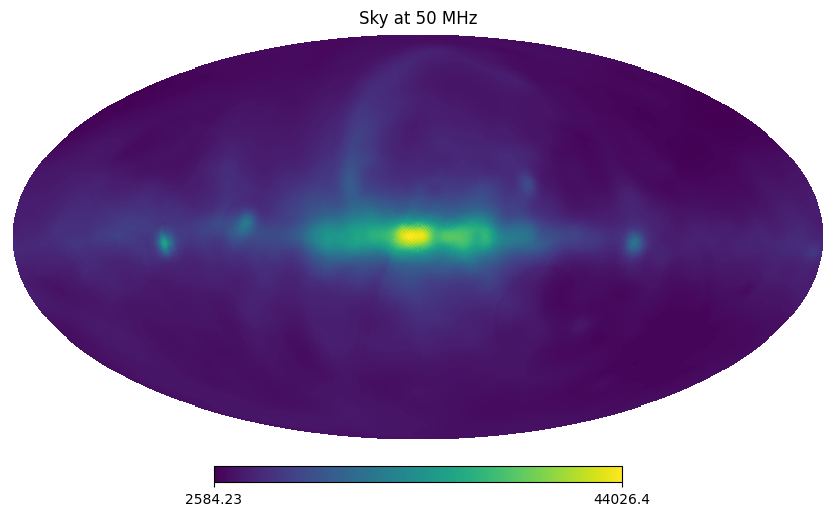

In [9]:
freqs = jnp.linspace(10, 50, 41)
lmax = 128
sky = crojax.Sky.gsm(freqs, lmax=lmax)
ix = -1
m = sky.alm2map(sampling="healpix", nside=64, frequencies=freqs[ix])
mollview(m[0], title=f"Sky at {freqs[ix]:.0f} MHz")

In [58]:
jnp.fft.fftfreq?

Signature:
jnp.fft.fftfreq(
    n: int,
    d: Union[jax.Array, numpy.ndarray, numpy.bool_, numpy.number, bool, int, float, complex] = 1.0,
    *,
    dtype=None,
) -> jax.Array
Docstring:
Return the Discrete Fourier Transform sample frequencies.

LAX-backend implementation of :func:`numpy.fft.fftfreq`.

*Original docstring below.*

The returned float array `f` contains the frequency bin centers in cycles
per unit of the sample spacing (with zero at the start).  For instance, if
the sample spacing is in seconds, then the frequency unit is cycles/second.

Given a window length `n` and a sample spacing `d`::

  f = [0, 1, ...,   n/2-1,     -n/2, ..., -1] / (d*n)   if n is even
  f = [0, 1, ..., (n-1)/2, -(n-1)/2, ..., -1] / (d*n)   if n is odd

Parameters
----------
n : int
    Window length.
d : scalar, optional
    Sample spacing (inverse of the sampling rate). Defaults to 1.
dtype : Optional
    The dtype of the returned frequencies. If not specified, JAX's default
    floating point 

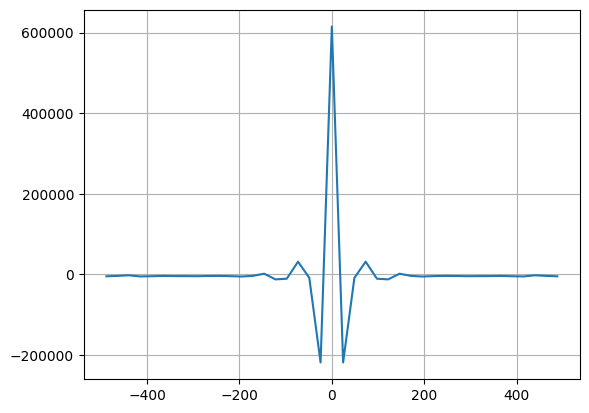

In [80]:
plt.figure()
plt.plot(jnp.fft.fftshift(jnp.fft.fftfreq(freqs.size, 1e6*(freqs[1]-freqs[0])))*1e9, jnp.fft.fftshift(jnp.fft.fft(beam[:, 0, 0])))
plt.grid()
plt.show()

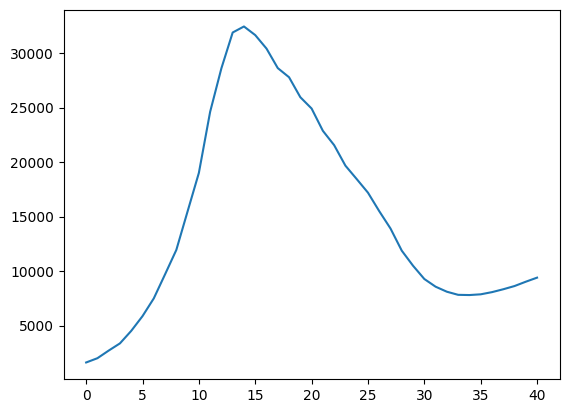

In [79]:
plt.figure()
plt.plot(beam[:, 0, 0].real)
plt.show()

In [34]:
from croissant import dpss

In [69]:
def res(nterms):
    A = dpss.dpss_op(freqs, filter_half_width=100e-9, nterms=nterms)
    M = jnp.linalg.inv(A.T @ A) @ A.T
    cs = jnp.einsum("ij, jlm -> ilm", M, sky.alm)
    ss = jnp.einsum("ij, jlm -> ilm", A, cs)
    return jnp.abs(ss-sky.alm)

In [76]:
rm = jnp.empty(41)
for i in range(41):
    rm = rm.at[i].set(res(i+1).mean())

plt.figure()
plt.plot(rm)
plt.yscale('log')
plt.show()

In [26]:
from functools import partial
def map2alm(m, lmax):
    forward = partial(
        s2fft.forward_jax, spin=0, nside=None, sampling="mw", reality=True, precomps=None, spmd=True, L_lower=0
    )
    L = lmax + 1
    return jax.vmap(forward, in_axes=(0, None))(m, L)


In [32]:
beam = jnp.load("lusee_beam.npy")[:, 9:, :, :-1]
beam = jnp.sqrt(jnp.abs(beam[0])**2 + jnp.abs(beam[1])**2)
beam = jnp.append(beam, jnp.zeros_like(beam)[:, :-1], axis=1)
beam_alm = map2alm(beam, lmax)
beam = crojax.Beam(beam_alm, frequencies=freqs, coord="T")

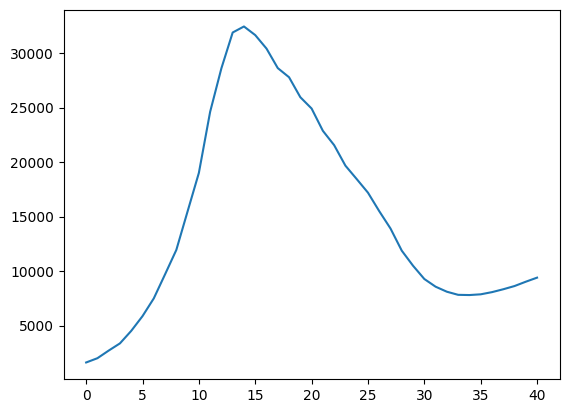

In [33]:
plt.figure()
plt.plot(beam[:, 0, 0])
plt.show()

In [84]:
def res(nterms):
    A = dpss.dpss_op(freqs, filter_half_width=50e-9, nterms=nterms)
    M = jnp.linalg.inv(A.T @ A) @ A.T
    cs = jnp.einsum("ij, jlm -> ilm", M, beam.alm)
    ss = jnp.einsum("ij, jlm -> ilm", A, cs)
    return jnp.abs(ss-beam.alm) / jnp.abs(beam.alm)

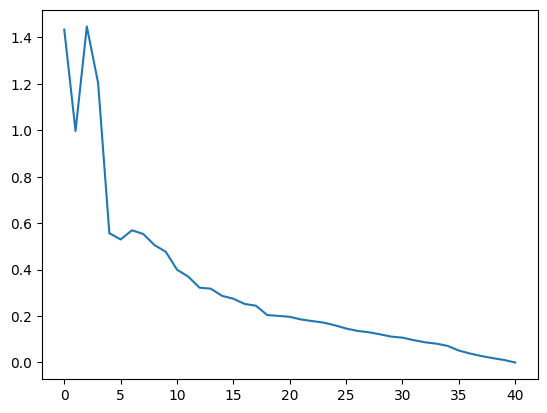

In [91]:
rm = jnp.empty(41)
for i in range(41):
    rm = rm.at[i].set(jnp.nanmean(res(i+1)))

plt.figure()
plt.plot(rm)
#plt.yscale('log')
plt.show()